# DSCI 100 Final Group Project Report: Joanne, Jaslyne, Maisha & William 
## Can the start time predict the playing session length in sessions.csv?

## **Introduction**

## **Method & Results**

### Methods
- **Method**: Use KNN regression to build a model that predicts the session time in minutes when given the start time (in hour:minute).

### Loading Libraries

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(hms)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading Data

In [4]:
session_data <- read_csv("https://raw.githubusercontent.com/jaslynemarek/DSCI-Project-Individual/refs/heads/main/sessions.csv")
head(session_data)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### Data Wrangling

In [5]:
session_data_dmyhm <- session_data |>
                    mutate(start_time = dmy_hm(start_time),
                    end_time = dmy_hm(end_time))
head(session_data_dmyhm)

session_data_mutated <- mutate(session_data_dmyhm, session_time = end_time - start_time,
                              start_time_hms = as_hms(start_time),
                              session_time = as.numeric(session_time),
                              start_time_numeric = as.numeric(start_time_hms))
head(session_data_mutated)

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12


hashedEmail,start_time,end_time,original_start_time,original_end_time,session_time,start_time_hms,start_time_numeric
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,12,18:12:00,65520
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,13,23:33:00,84780
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,23,17:34:00,63240
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12,36,03:22:00,12120
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12,11,16:01:00,57660
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12,122,15:08:00,54480


### Dataset Summary

About sessions.csv:
- features variables such as the player's email, start and end time, and has been wrangled to include the session time in minutes, the start time in hours, and the numeric start time in seconds since midnight to make regression easier
- has 1535 observations, each representing a playing session

Summary Statistics:
| Mean Session Length (minutes) | Minimum Session Length (minutes) | Maximum Session Length (minutes) |
|:-------------------:|:----------------------:|:----------------------:|
|50.85|3|259|


In [16]:
session_time_statistics <- summarize(session_data_mutated, mean_session_time = mean(session_time, na.rm = TRUE),
                                    min_session_time = min(session_time, na.rm = TRUE),
                                    max_session_time = max(session_time, na.rm = TRUE))
session_time_statistics


mean_session_time,min_session_time,max_session_time
<dbl>,<dbl>,<dbl>
50.85845,3,259


### Visualization

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


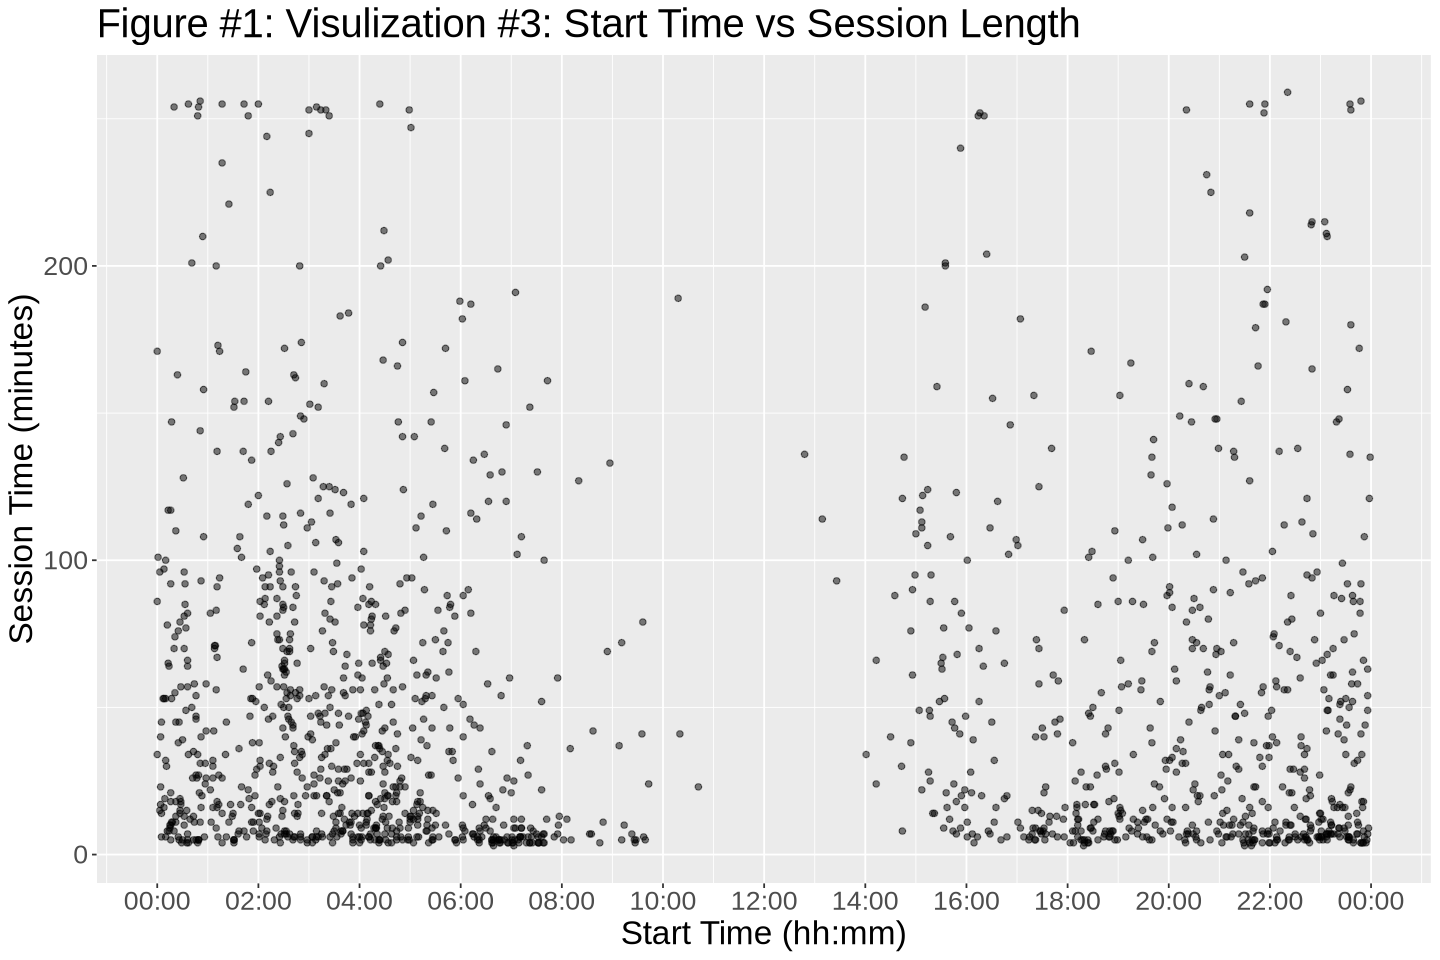

In [18]:
options(repr.plot.width = 12, repr.plot.height = 8)
time_plot <- ggplot(session_data_mutated, aes(x = start_time_hms, y = session_time))+
            geom_point(alpha = 0.5)+
            xlab("Start Time (hh:mm)")+
            ylab("Session Time (minutes)")+
            ggtitle("Figure #1: Visulization #3: Start Time vs Session Length")+
            theme(text = element_text(size = 20))+
            scale_x_time(breaks = seq(0,24*3600, by = 2*3600), labels = scales::time_format("%H:%M"))
time_plot

Very few players are starting their sessions between 08:00 and 14:00, server is busy otherwise.

### Data Analysis

First we begin with splitting the data into different sets of training and testing so that we can build our model, and then test it using unseen data. The proportion of this split is 75% to 25%, with 75% of the data going towards the training: building the model, and 25% to testing: evaluating how well the regression model works.

In [41]:
session_split <- initial_split(session_data_mutated, prop = 0.75, strata = session_time)
session_train <- training(session_split)
session_test <- testing(session_split)

In [42]:
minecraft_recipe <- recipe(session_time ~ start_time_numeric, data = session_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

minecraft_spec <- nearest_neighbor(weight_func = "rectangular",
                                                   neighbors = tune())|>
                set_engine("kknn")|>
                set_mode("regression")

minecraft_vfold <- vfold_cv(session_train, v = 5, strata = session_time)

minecraft_workflow <- workflow() |>
                        add_recipe(minecraft_recipe)|>
                        add_model(minecraft_spec)
minecraft_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [43]:
gridvals <- tibble(neighbors = seq(from = 1, to = 300, by = 2))

sessions_results <- minecraft_workflow |>
                tune_grid(resamples = minecraft_vfold, grid = gridvals)|>
                collect_metrics()|>
                filter(.metric == "rmse")

head(sessions_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,72.91708,5,3.366595,Preprocessor1_Model001
3,rmse,standard,60.31547,5,2.689541,Preprocessor1_Model002
5,rmse,standard,57.95062,5,2.440568,Preprocessor1_Model003
7,rmse,standard,57.14184,5,2.527068,Preprocessor1_Model004
9,rmse,standard,56.61952,5,2.419929,Preprocessor1_Model005
11,rmse,standard,56.64981,5,2.367591,Preprocessor1_Model006


In [44]:
sessions_min <- sacr_results |>
            filter(mean == min(mean))
sessions_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,rmse,standard,55.00051,5,2.036116,Preprocessor1_Model041


In [45]:
kmin <- sacr_min |> pull(neighbors)

sessions_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                set_engine("kknn") |>
                set_mode("regression")

sessions_fit <- workflow()|>
                add_recipe(minecraft_recipe) |>
                add_model(sessions_spec) |>
                fit(data = session_train)

sessions_summary <- sessions_fit |>
                    predict(session_test) |>
                    bind_cols(session_test) |>
                    metrics(truth = session_time, estimate = .pred)|>
                    filter(.metric == 'rmse')
sessions_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,56.57501


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


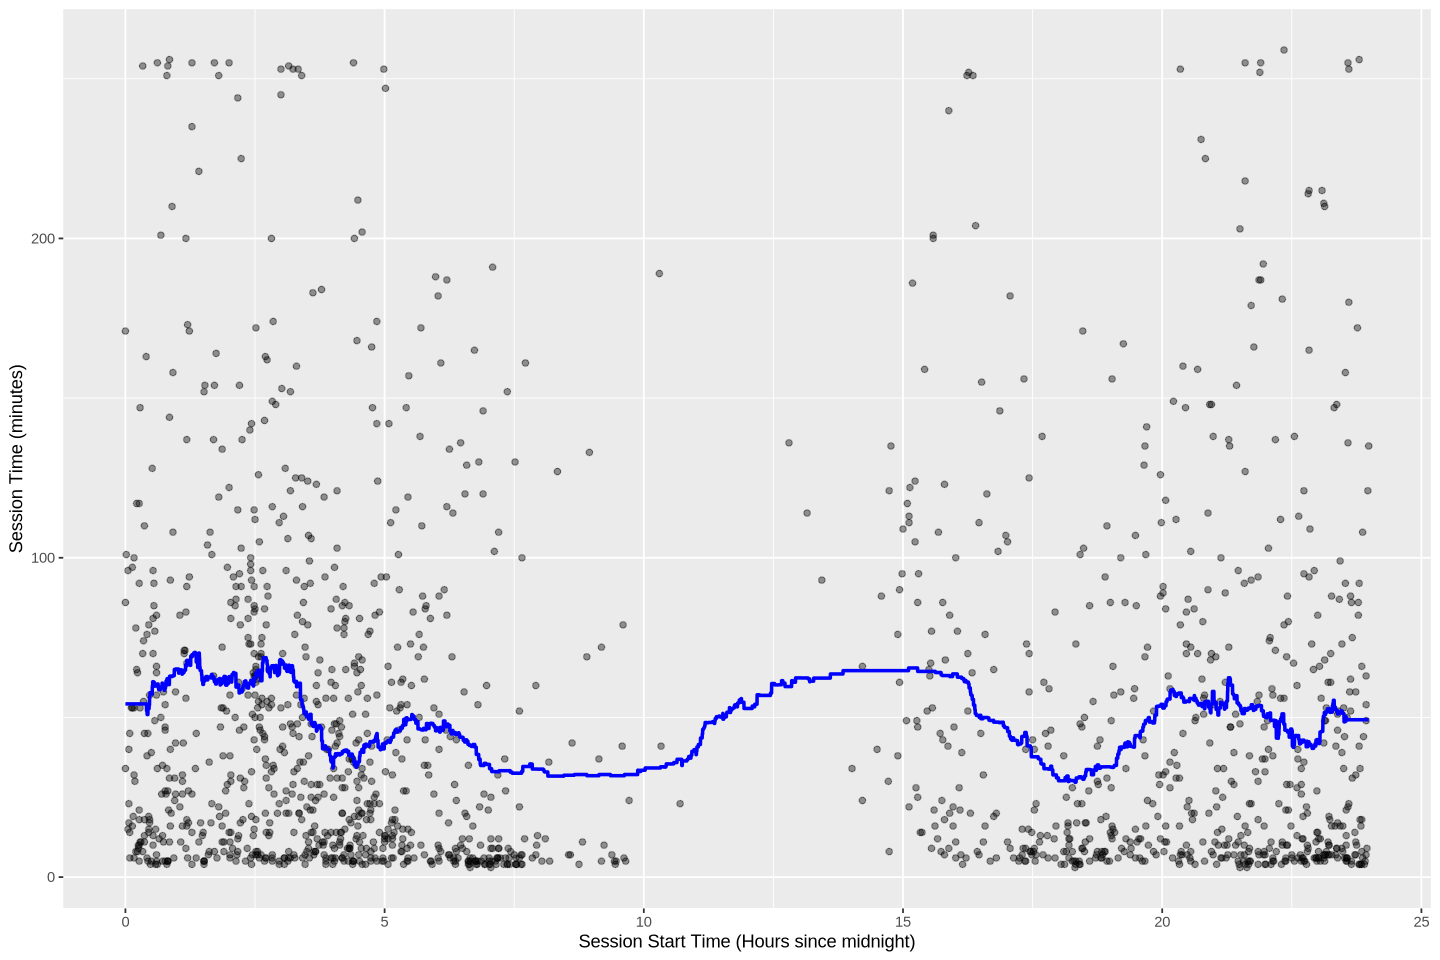

In [50]:
minecraft_prediction_grid <- tibble(start_time_numeric = seq(
                                from = min(pull(session_data_mutated, start_time_numeric)),
                                to = max(pull(session_data_mutated, start_time_numeric)),
                                by = 10))

session_preds <- sessions_fit |>
                    predict(minecraft_prediction_grid)|>
                    bind_cols(minecraft_prediction_grid)

plot_final <- ggplot(session_data_mutated, aes( x = start_time_numeric/3600, y = session_time))+
                geom_point(alpha = 0.4)+
                geom_line(data = session_preds,
                          mapping = aes( x = start_time_numeric/3600, y = .pred),
                          color = "blue",
                          linewidth = 1)+
                xlab("Session Start Time (Hours since midnight)")+
                ylab("Session Time (minutes)")
plot_final

## **Discussion**

## **References**